# Carbon dioxide Analysis

### Setup  
Import libraries for data handling (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), and path management (`pathlib`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import plotly.express as px
import os
import plotly.io as pio

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### File path setup  
Define the base directory and specify the input path for the **pre-processed CO₂ emissions dataset** (`Final_CO2_Emissions_Dataset.csv`).

In [2]:
# Base directory
BASE_DIR = Path().resolve().parents[1]
INPUT_PATH = BASE_DIR / "data" / "pre_processed" / "Final_CO2_Emissions_Dataset.csv"

Configure Seaborn to use a clean `whitegrid` style with larger text (`talk` context) for better readability in plots.

In [3]:
# Set plot style
sns.set(style="whitegrid", context="talk")

### Analysis 1: Global CO₂ emissions data preparation  
- Load the **CO₂ emissions dataset**.  
- Clean the `year` column and ensure it is integer type.  
- Filter only the **World aggregate** (excluding individual countries).  
- Convert CO₂ values to numeric and fill missing values with 0.  
- Compute **total emissions including land-use change (LUC)** by combining fossil fuel/industry CO₂ with `land_use_change_co2`.  

This prepares the baseline global CO₂ emissions series for further trend analysis.

In [4]:
# Analysis 1

# Load and clean data
df = pd.read_csv(INPUT_PATH)
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)

# Filter WORLD data
df_world = df[df['country'].str.upper() == 'WORLD'].copy()

# Convert and clean relevant columns
df_world['co2'] = pd.to_numeric(df_world['co2'], errors='coerce').fillna(0)
df_world['land_use_change_co2'] = pd.to_numeric(df_world['land_use_change_co2'], errors='coerce').fillna(0)

# Compute total emissions including LUC
df_world['co2_including_luc'] = df_world['co2'] + df_world['land_use_change_co2']

### Plot: Global CO₂ emissions (1750–2023)  
- **Blue line:** Fossil fuel & industrial CO₂ emissions (in MtCO₂).  
- **Dashed orange line:** Total emissions including **land-use change (LUC)** such as deforestation and agriculture.  
- **Vertical markers:**  
  - **1990 (gray):** Kyoto Protocol – first binding climate treaty.  
  - **2015 (red):** Paris Agreement – universal climate accord.  

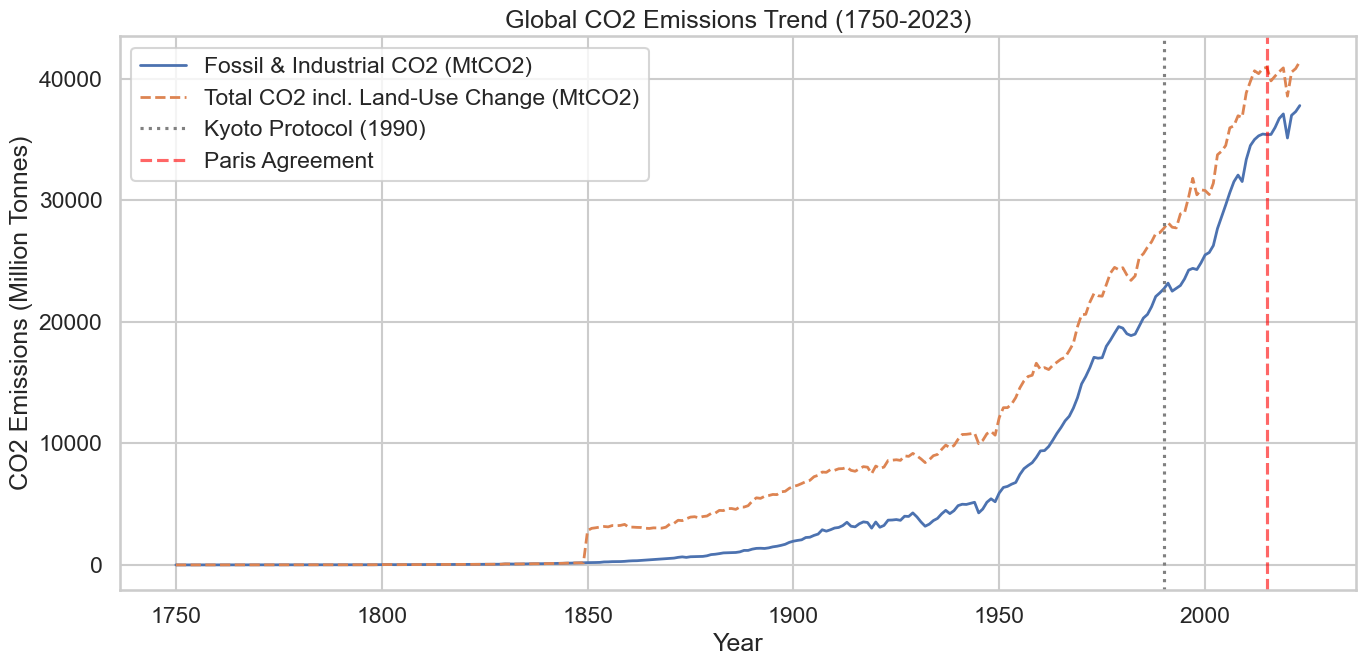

In [5]:
# Plot
plt.figure(figsize=(14, 7))
plt.plot(df_world['year'], df_world['co2'], label='Fossil & Industrial CO2 (MtCO2)', linewidth=2)
plt.plot(df_world['year'], df_world['co2_including_luc'], label='Total CO2 incl. Land-Use Change (MtCO2)', linestyle='--', linewidth=2)

# annotations
plt.axvline(x=1990, color='gray', linestyle=':', label='Kyoto Protocol (1990)')
plt.axvline(x=2015, color='red', linestyle='--', alpha=0.6, label='Paris Agreement')

plt.title("Global CO2 Emissions Trend (1750-2023)", fontsize=18)
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (Million Tonnes)")
plt.legend()
plt.tight_layout()

# show plot
plt.show()

- **Blue line:** Fossil fuel & industrial emissions (MtCO₂).  
- **Orange dashed line:** Total CO₂ including land-use change (LUC).  
- **Gray dotted line (1990):** Kyoto Protocol — first climate treaty.  
- **Red dashed line (2015):** Paris Agreement — universal climate accord.  

CO₂ emissions were negligible before the Industrial Revolution, then accelerated after 1950.  
Despite international agreements, global emissions continue rising, now exceeding **40,000 MtCO₂ per year (≈40 GtCO₂)**.


### Analysis 2: Prepare country-level CO₂ snapshot (latest year)
- Load the CO₂ dataset and clean core fields (`year`, `co2`).
- **Filter scope:** keep individual countries; drop global/aggregate lines  
  (`WORLD`, `INTERNATIONAL TRANSPORT/SHIPPING/AVIATION`, `DISPUTED`).  
- Identify the **most recent reporting year** and subset to that year (`df_latest`) for rankings/maps/comparisons.


In [6]:
# Analysis 2

# Load and clean data
df = pd.read_csv(INPUT_PATH)
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)
df['co2'] = pd.to_numeric(df['co2'], errors='coerce')

excluded_entities = [
    'WORLD',
    'INTERNATIONAL TRANSPORT',
    'INTERNATIONAL SHIPPING',
    'INTERNATIONAL AVIATION',
    'DISPUTED'
]
df = df[~df['country'].str.upper().isin(excluded_entities)]

# Determine latest year
latest_year = df[df['co2'].notnull()]['year'].max()
df_latest = df[df['year'] == latest_year]

### Visualization: Top 10 CO₂ emitting countries (latest year)  
- Select the **10 largest emitters** by annual CO₂ output.  
- Horizontal bar chart shows emissions in **million tonnes (MtCO₂)**.  
- Each bar is labeled with the exact emission value.  

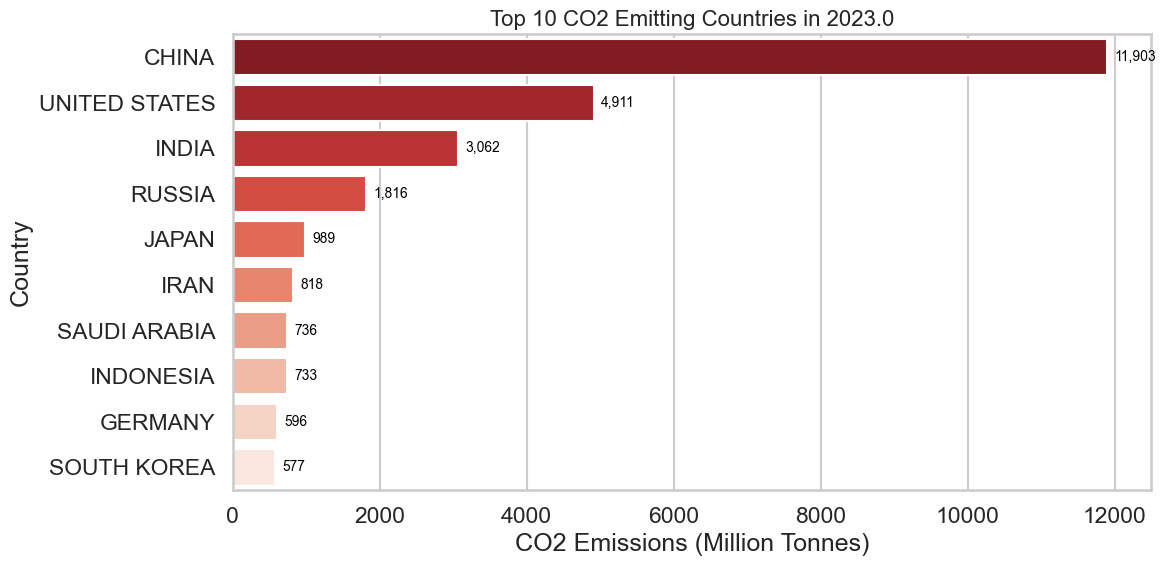

In [ ]:
import warnings
warnings.filterwarnings("ignore")

top_emitters = df_latest.nlargest(10, 'co2')[['country', 'co2']]

plt.figure(figsize=(12, 6))
sns.barplot(data=top_emitters, x='co2', y='country', hue=None, palette='Reds_r', legend=False)

# Annotate bars
for i, (co2_value, country) in enumerate(zip(top_emitters['co2'], top_emitters['country'])):
    plt.text(co2_value + 100, i, f"{co2_value:,.0f}", va='center', fontsize=10, color='black')

plt.title(f"Top 10 CO2 Emitting Countries in {latest_year}", fontsize=16)
plt.xlabel("CO2 Emissions (Million Tonnes)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

- **China** dominates with ~11,900 MtCO₂ — more than double the US (~4,900 MtCO₂).  
- **India** (~3,000 MtCO₂) has shown rapid growth, reflecting post-1990 industrialization.  
- Other top emitters include Russia, Japan, Iran, Saudi Arabia, Indonesia, Germany, and South Korea.  

**Key message:** Just **three countries (China, US, India)** account for over **50% of global CO₂ emissions**, highlighting the unequal distribution of responsibility and the importance of their policies for climate outcomes.


### Visualization: CO₂ emissions over time for top 5 countries  
- Line chart of historical emissions for the **top 5 emitters** (China, US, India, Russia, Japan).  
- **Vertical markers:**  
  - **1990 (gray):** Kyoto Protocol.  
  - **2015 (red):** Paris Agreement.  

This comparison highlights how global emission trends are **dominated by policy, industrialization, and energy choices** in a handful of countries.

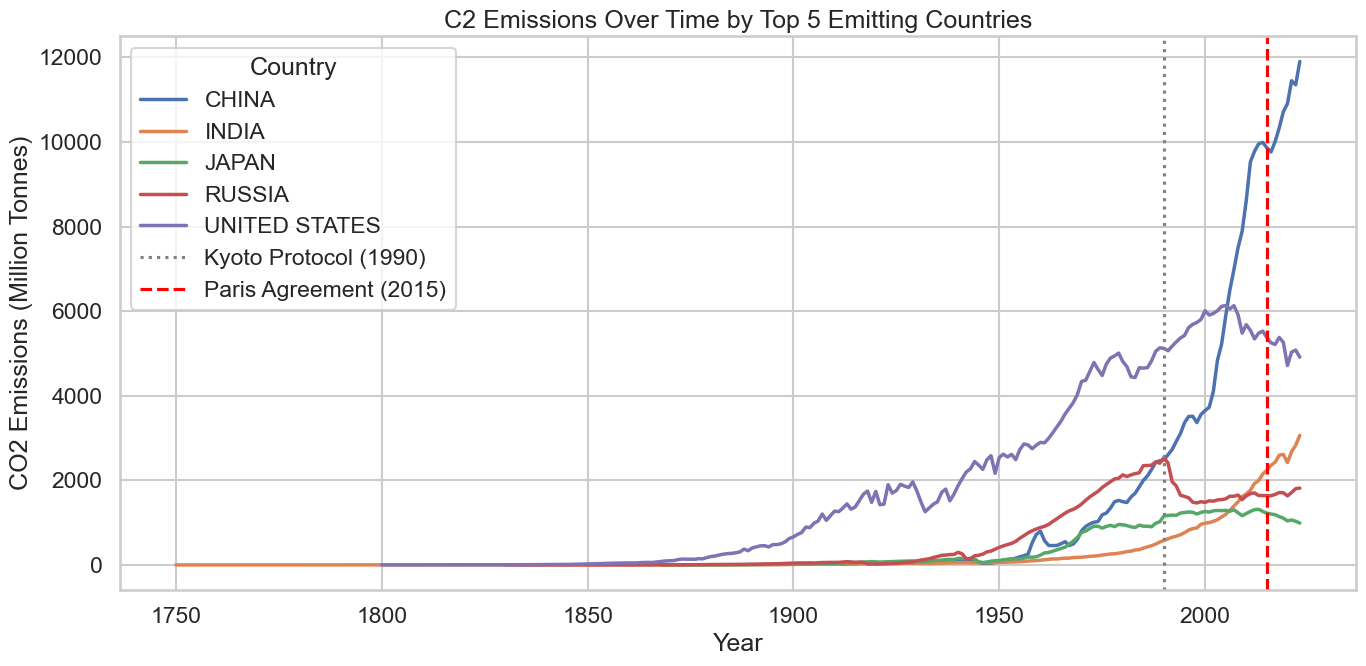

In [ ]:
top5_countries = top_emitters.head(5)['country'].tolist()
df_top5_trend = df[df['country'].isin(top5_countries)]

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_top5_trend, x='year', y='co2', hue='country', linewidth=2.5)

# Annotate policy milestones
plt.axvline(x=1990, color='gray', linestyle=':', label='Kyoto Protocol (1990)')
plt.axvline(x=2015, color='red', linestyle='--', label='Paris Agreement (2015)')

plt.title(f"C2 Emissions Over Time by Top 5 Emitting Countries", fontsize=18)
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (Million Tonnes)")
plt.legend(title="Country")
plt.tight_layout()

# Show Plot
plt.show()


- **China**: Explosive rise after 2000, now the world’s largest emitter.  
- **United States**: Strong rise through the 20th century, peak around 2005, then decline.  
- **India**: Continuous growth, accelerating after 1990, reflecting rapid industrialization.  
- **Russia**: Growth until the early 1990s, then a sharp fall after the Soviet collapse, stabilizing later.  
- **Japan**: Moderate emissions with no recent growth.  

**Key insight:** The global emission trajectory is dominated by the policy and energy choices of a few countries. Even with international agreements, major emitters continue to drive overall growth.

### Analysis 3: CO₂ emissions by fuel type
- Load and clean global CO₂ dataset, focusing on **fuel-specific columns**:  
  - Cement, Coal, Flaring, Gas, Oil, and Other Industry.  
- Convert to numeric, handle missing values, and sort by year.  
- Plot a **stacked area chart** to show the contribution of each fuel type to total emissions.  

This breakdown highlights the **fuel-driven nature of CO₂ growth** and shows why transitioning energy systems away from fossil fuels is critical.

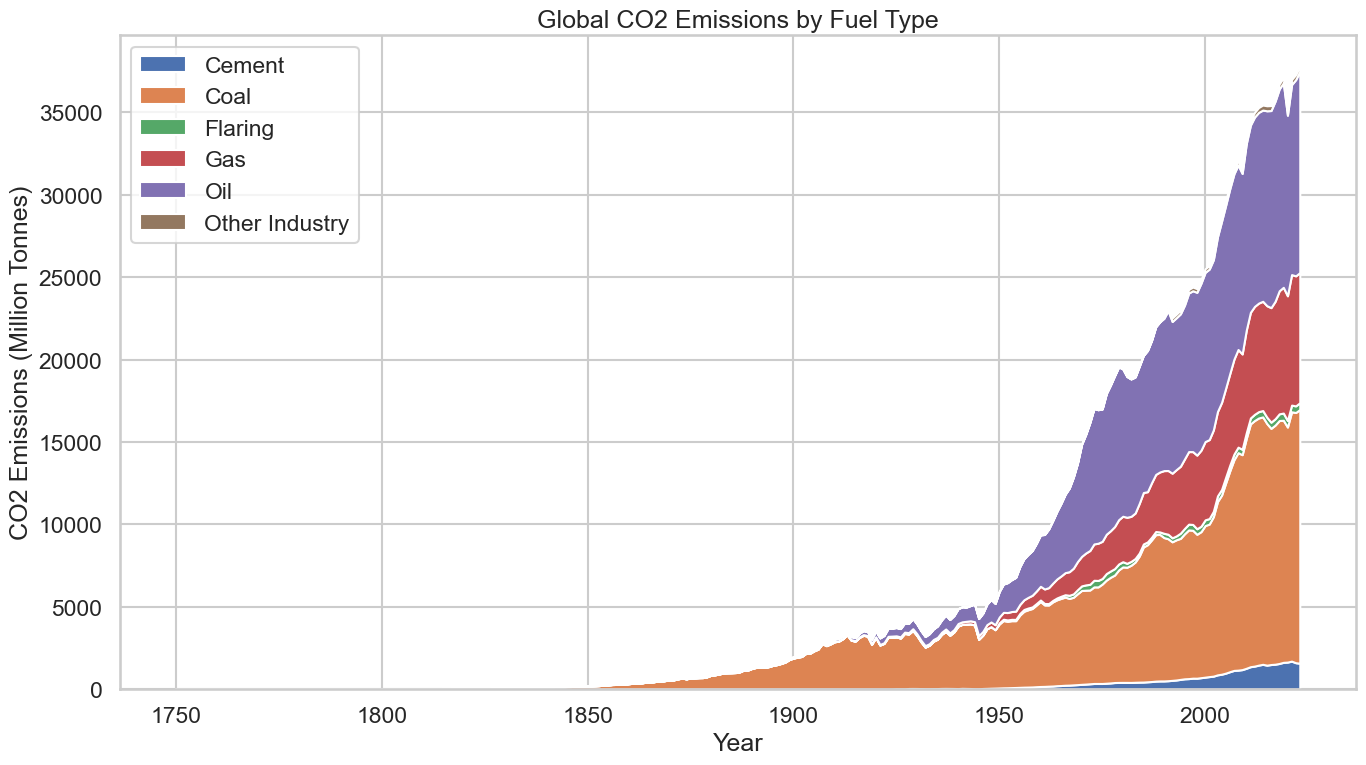

In [ ]:
#Analysis 3

# Load and clean data
df = pd.read_csv(INPUT_PATH)
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)
df['co2'] = pd.to_numeric(df['co2'], errors='coerce')

# Subset WORLD data
df_world = df[df['country'].str.upper() == 'WORLD'].copy()

# Convert fuel columns to numeric and handle NaNs
fuel_cols = ['cement_co2', 'coal_co2', 'flaring_co2', 'gas_co2', 'oil_co2', 'other_industry_co2']
df_world[fuel_cols] = df_world[fuel_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Sort by year
df_world = df_world.sort_values('year')

# Plot stacked area chart
plt.figure(figsize=(14, 8))
plt.stackplot(df_world['year'], 
              [df_world[col] for col in fuel_cols],
              labels=['Cement', 'Coal', 'Flaring', 'Gas', 'Oil', 'Other Industry'])

# Formatting
plt.title("Global CO2 Emissions by Fuel Type", fontsize=18)
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (Million Tonnes)")
plt.legend(loc="upper left")
plt.tight_layout()

# Show Plot
plt.show()

Shows the contribution of **different fuels and industries** to total global CO₂ emissions.  
- **Coal** (orange) is the largest contributor, accelerating after 1950.  
- **Oil** (purple) rose steeply after WWII, becoming the second-largest source.  
- **Gas** (red) has grown steadily since the 1970s.  
- **Cement** (blue) and **other industries** (brown) are smaller but steadily rising.  
- **Flaring** (green) is consistently minimal.  

**Key insight:** The global emissions surge is dominated by **coal, oil, and gas**, underscoring the challenge of phasing out fossil fuels in the energy mix.

### Analysis 4: Fuel shares in global CO₂ emissions  
- Focus on **World totals** and ensure years are sorted.  
- For each row (year), calculate the **total CO₂ across all fuel types**.  
- Compute percentage contribution (`fuel / total * 100`) for each fuel type:  
  - Cement, Coal, Flaring, Gas, Oil, Other Industry.  
- Replace invalid values (e.g., divide-by-zero cases) with 0.  

This prepares the dataset for visualizing the **relative share of each fuel** in global CO₂ emissions over time.


In [ ]:
# Fuel columns (as found in your notebook)
fuel_cols = ['cement_co2', 'coal_co2', 'flaring_co2', 'gas_co2', 'oil_co2', 'other_industry_co2']

# Ensure WORLD subset and sorted years
df_world = df[df['country'].str.upper() == 'WORLD'].copy()
df_world = df_world.sort_values('year')
df_world['year'] = pd.to_numeric(df_world['year'], errors='coerce')

# Row-wise total and percentage columns
row_total = df_world[fuel_cols].sum(axis=1)
for col in fuel_cols:
    df_world[f'{col}_pct'] = (df_world[col] / row_total) * 100

# Clean any NaNs/infs produced by division (e.g., if a row_total == 0)
pct_cols = [f'{c}_pct' for c in fuel_cols]
df_world[pct_cols] = df_world[pct_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

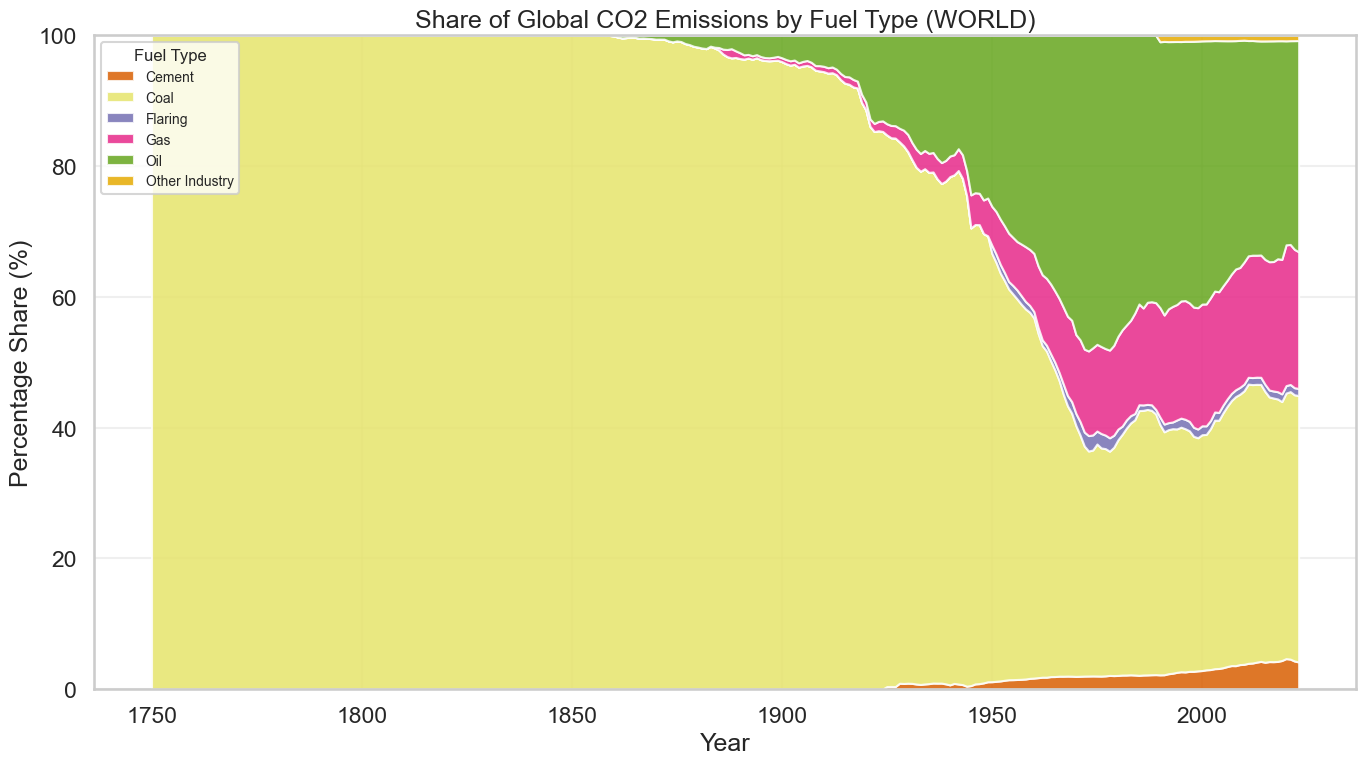

In [ ]:
# Set custom color palette (6 colors for 6 series)
colors = ['#d95f02', '#e6e46b', '#7570b3', '#e7298a', '#66a61e', '#e6ab02']

# Plot
plt.figure(figsize=(14, 8))
plt.stackplot(
    df_world['year'].to_numpy(),
    *[df_world[c].to_numpy() for c in pct_cols],
    labels=['Cement', 'Coal', 'Flaring', 'Gas', 'Oil', 'Other Industry'],
    colors=colors,
    alpha=0.85
)

plt.title("Share of Global CO2 Emissions by Fuel Type (WORLD)", fontsize=18)
plt.xlabel("Year")
plt.ylabel("Percentage Share (%)")
plt.ylim(0, 100)
plt.legend(loc='upper left', title='Fuel Type', fontsize=10, title_fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Analysis 4: Land-Use Change vs Fossil Fuels

# Reload a clean copy of the dataset
df_luc = pd.read_csv(INPUT_PATH)

# Clean numeric fields
df_luc['year'] = pd.to_numeric(df_luc['year'], errors='coerce')
df_luc['co2'] = pd.to_numeric(df_luc['co2'], errors='coerce').fillna(0)
df_luc['land_use_change_co2'] = pd.to_numeric(df_luc['land_use_change_co2'], errors='coerce').fillna(0)

# Compute total and LUC share
df_luc['total_emissions'] = df_luc['co2'] + df_luc['land_use_change_co2']
df_luc = df_luc[df_luc['total_emissions'] > 0]  # remove rows with 0 total emissions
df_luc['land_use_share'] = df_luc['land_use_change_co2'] / df_luc['total_emissions']

# Filter for latest year and remove aggregates
latest_year = df_luc['year'].max()
excluded_entities = [
    'WORLD',
    'INTERNATIONAL TRANSPORT',
    'INTERNATIONAL SHIPPING',
    'INTERNATIONAL AVIATION',
    'DISPUTED'
]
df_latest = df_luc[(df_luc['year'] == latest_year) & (~df_luc['country'].str.upper().isin(excluded_entities))]

# Top 15 countries with highest land-use share
top_luc_share = df_latest.sort_values('land_use_share', ascending=False).head(15)

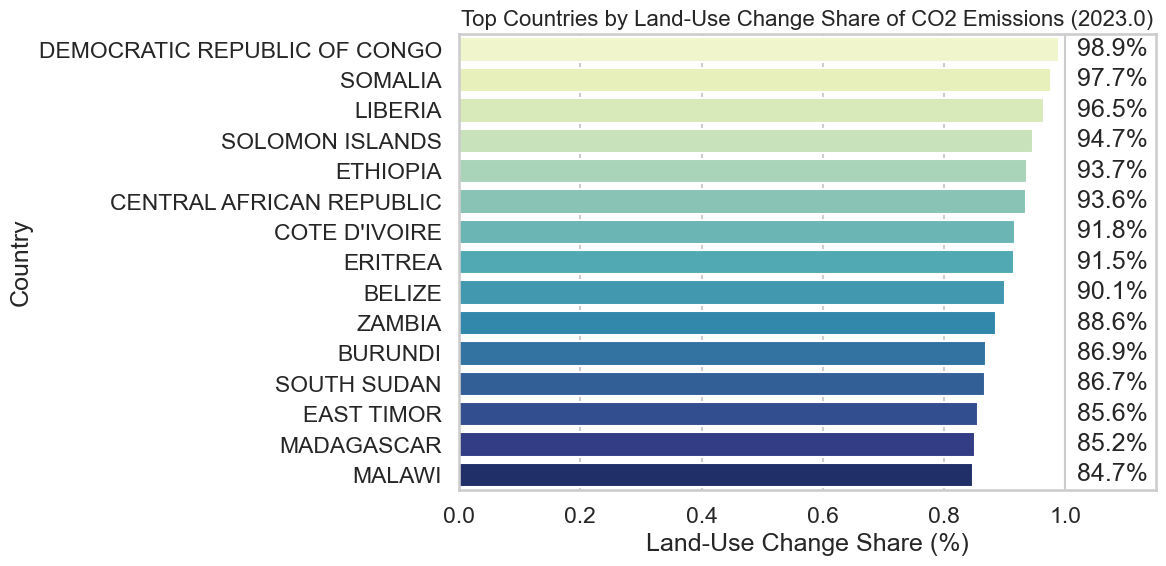

In [ ]:
warnings.filterwarnings("ignore")

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=top_luc_share, x='land_use_share', y='country', palette='YlGnBu')
plt.title(f"Top Countries by Land-Use Change Share of CO2 Emissions ({latest_year})", fontsize=16)
plt.xlabel("Land-Use Change Share (%)")
plt.ylabel("Country")

# Set xlim a bit wider so there's space for labels
plt.xlim(0, 1.15)

# Annotate % values outside the bars
for i, val in enumerate(top_luc_share['land_use_share']):
    plt.text(1.02, i, f"{val*100:.1f}%", va='center')  # fixed x-position outside the chart

plt.tight_layout()
plt.show()

- The chart shows the top 15 countries where emissions are dominated by land-use change (LUC) rather than fossil fuels.
- Democratic Republic of Congo, Somalia, and Liberia top the list, with >95% of their emissions from LUC.
- Most countries in the list are African nations or developing regions with limited industrial emissions but high deforestation.
- LUC share in these countries often exceeds 85–98%, meaning fossil-fuel emissions are almost negligible.

This highlights the critical role of forest conservation and sustainable land practices in global climate strategies, especially for these regions.

### Choropleth: Share of CO₂ Emissions from Land-Use Change
- Uses `plotly.express.choropleth` to create an interactive world map.  
- Colors each country by the share of its CO₂ emissions from land-use change (`land_use_share`).  
- Data source: `df_latest`, filtered for the most recent year (2023).  
- Yellow–Green–Blue color scale highlights differences (low → high).  
- Hover tooltips show country name and exact percentage.  
- Layout removes borders, keeps coastlines, and formats colorbar in %.  

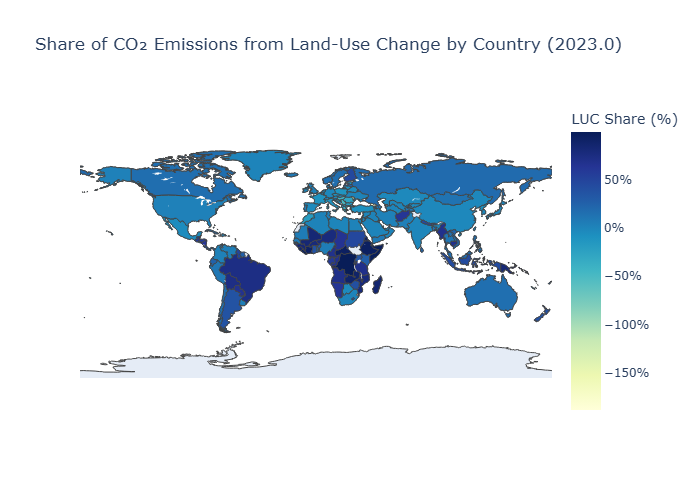

In [ ]:
warnings.filterwarnings("ignore")

# Choropleth using already cleaned `df_luc`
fig = px.choropleth(
    df_latest,  # from previous steps in your notebook
    locations="country",
    locationmode="country names",
    color="land_use_share",
    hover_name="country",
    color_continuous_scale="YlGnBu",
    title=f"Share of CO₂ Emissions from Land-Use Change by Country ({latest_year})",
    labels={"land_use_share": "Land-Use CO₂ Share"}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title="LUC Share (%)", tickformat=".0%")
)

fig.show()

### Analysis 5: Production vs. Consumption accounting
- Reload a clean copy of the dataset and coerce key fields to numeric: `year`, `co2` (production-based), `consumption_co2`, `trade_co2`.
- Drop rows with missing values in any of these fields.
- Subset to focus countries: China, United States, India, Russia, Japan, United Kingdom, Germany, Ireland.
- Purpose: compare **where emissions are produced** vs **where goods are consumed**, using `trade_co2` (net imports = consumption − production) to reveal offshoring of carbon.

In [ ]:
# Analysis 5: Production vs. Consumption Accounting

# Reload clean dataset to avoid modified df
df_trade = pd.read_csv(INPUT_PATH)

# Clean and prepare numeric fields
df_trade['year'] = pd.to_numeric(df_trade['year'], errors='coerce')
df_trade['co2'] = pd.to_numeric(df_trade['co2'], errors='coerce')  # production-based
df_trade['consumption_co2'] = pd.to_numeric(df_trade['consumption_co2'], errors='coerce')
df_trade['trade_co2'] = pd.to_numeric(df_trade['trade_co2'], errors='coerce')

# Filter valid rows
df_trade = df_trade.dropna(subset=['year', 'co2', 'consumption_co2', 'trade_co2'])

# Focus on selected countries (Germany, UK, China, USA, India)
focus_countries = ['CHINA', 'UNITED STATES', 'INDIA', 'RUSSIA', 'JAPAN', 'UNITED KINGDOM', 'GERMANY', 'IRELAND']
df_focus = df_trade[df_trade['country'].isin(focus_countries)]

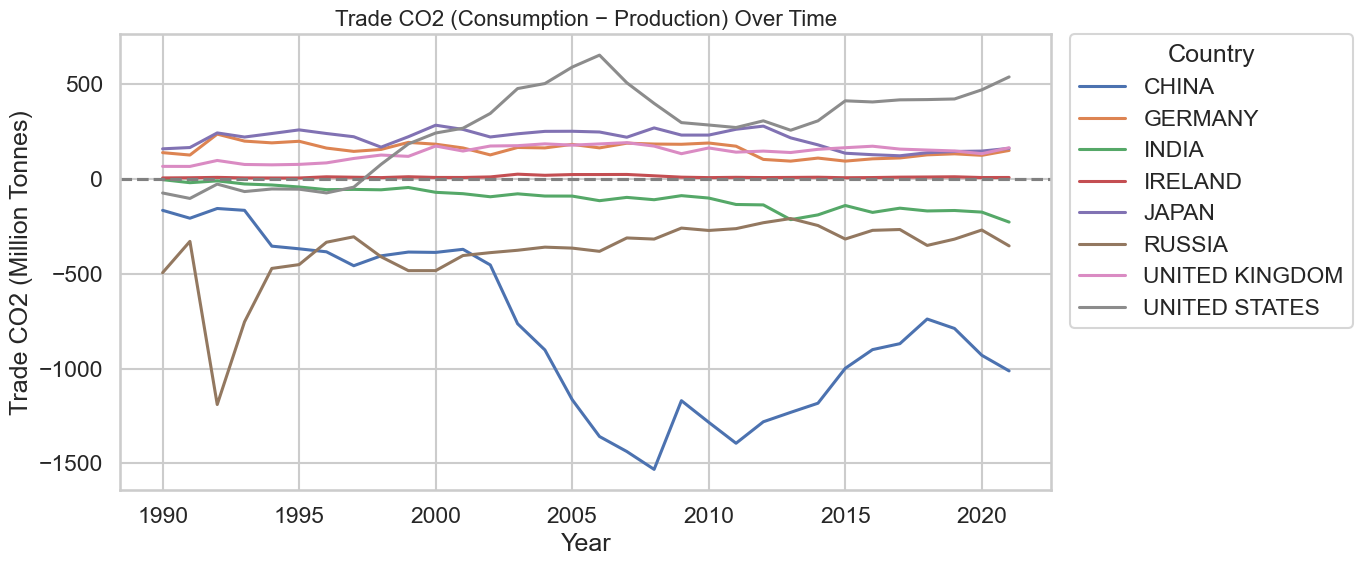

In [ ]:
# Step 5: Plot Trade CO₂ over time
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_focus, x='year', y='trade_co2', hue='country', linewidth=2.2)

# Horizontal reference line
plt.axhline(0, color='gray', linestyle='--')

# Labels and title
plt.title("Trade CO2 (Consumption − Production) Over Time", fontsize=16)
plt.ylabel("Trade CO2 (Million Tonnes)")
plt.xlabel("Year")

# Improved legend placement (outside the plot)
plt.legend(
    title="Country",
    bbox_to_anchor=(1.02, 1),  # move legend outside right
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()
plt.show()

Fitting auto_arima to determine best (p,d,q)...
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=3218.092, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3289.037, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3252.638, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=3245.832, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3287.146, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=3229.898, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=3227.877, Time=0.20 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=3219.617, Time=0.29 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=3219.600, Time=0.31 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=3232.586, Time=0.12 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=3227.765, Time=0.24 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=3228.595, Time=0.21 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=3221.599, Time=0.30 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3217.957,

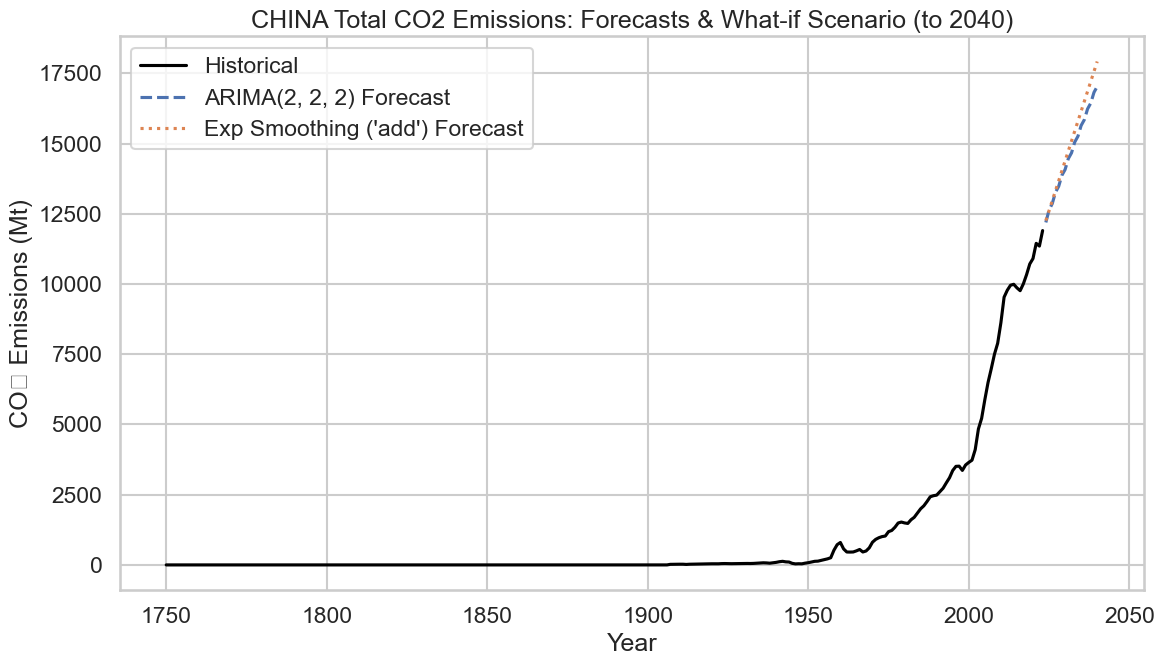


ARIMA(2, 2, 2) (AIC=3217.96) Forecasted Emissions:
  2030: 14074.24 Mt CO₂
  2040: 17032.03 Mt CO₂

Exp Smoothing ('add') (AIC=2492.01) Forecasted Emissions:
  2030: 14380.94 Mt CO₂
  2040: 17921.56 Mt CO₂


In [ ]:
#Analysis 6
try:
    import pmdarima as pm
except ImportError:
    pm = None

warnings.filterwarnings('ignore')

- **Utility – `load_country_series(input_path, country, emission_col)`**
  - Filter rows for a country (case-insensitive), sort by `year`, build a **Pandas Series** indexed by year.
  - Coerce to numeric; `NaN`→0 to avoid breaks in fitting.

- **Model search – `find_best_arima(ts)`**
  - Uses `pmdarima.auto_arima` *(non-seasonal)* to pick `(p,d,q)` by lowest **AIC**.
  - Args: `stepwise=True`, `max_p/q=4`, `max_d=2`, `seasonal=False`.
  - **Output:** best `(p,d,q)` and its AIC. *(Requires `pip install pmdarima`.)*

- **Model search – `find_best_es_trend(ts)`**
  - Tries Holt-Winters with trend ∈ {`None`, `'add'`, `'mul'`} (no seasonality).
  - Picks the **lowest AIC**; returns `best_trend` and AIC.

- **Forecast & plot – `forecast_and_plot(ts, arima_order, es_trend, forecast_end_year=2040)`**
  - Fits **ARIMA(order)** and **ExponentialSmoothing(trend)** on the historical series.
  - Forecasts yearly values up to `forecast_end_year`.
  - **Plot:** historical (black) + ARIMA (dashed) + ES (dotted), with legend and units (Mt CO₂).
  - **Console:** prints point forecasts for **2030** and **2040** for both models.
  - *(Optional what-if path for a 50% cut by 2040 is included but commented out.)*

- **Main run**
  - Set `country = 'CHINA'`, `emission_col = 'co2'` (production-based).
  - Run model selection → print summary → call `forecast_and_plot`.

In [ ]:
# Utility Functions

def load_country_series(input_path, country, emission_col):
    df = pd.read_csv(input_path)
    df_country = df[df['country'].str.strip().str.lower() == country.lower()]
    df_country = df_country.sort_values('year')
    years = df_country['year'].astype(int)
    emissions = df_country[emission_col].astype(float)
    ts = pd.Series(emissions.values, index=years)
    return ts.fillna(0)

def find_best_arima(ts):
    if pm is None:
        raise ImportError("pmdarima is not installed. Please install with pip install pmdarima.")
    print("Fitting auto_arima to determine best (p,d,q)...")
    arima_model = pm.auto_arima(ts, seasonal=False, trace=True,
                                error_action='ignore', suppress_warnings=True,
                                stepwise=True, max_p=4, max_q=4, max_d=2)
    print(f"Best ARIMA order: {arima_model.order} (AIC={arima_model.aic():.2f})")
    return arima_model.order, arima_model.aic()

def find_best_es_trend(ts):
    print("\nTesting different trends for Exponential Smoothing...")
    trend_options = [None, 'add', 'mul']
    best_trend = None
    best_aic = np.inf
    for trend in trend_options:
        try:
            model_es = ExponentialSmoothing(ts, trend=trend, seasonal=None)
            fit_es = model_es.fit()
            aic = fit_es.aic
            print(f"Trend: {trend}, AIC: {aic:.2f}")
            if aic < best_aic:
                best_aic = aic
                best_trend = trend
        except Exception as e:
            print(f"Trend: {trend}, Error: {e}")
    print(f"\nBest trend for Exponential Smoothing: {best_trend} (AIC={best_aic:.2f})")
    return best_trend, best_aic

def forecast_and_plot(ts, arima_order, es_trend, forecast_end_year=2040):
    forecast_years = np.arange(ts.index.max()+1, forecast_end_year+1)
    # ARIMA forecast
    model_arima = ARIMA(ts, order=arima_order)
    model_arima_fit = model_arima.fit()
    forecast_arima = model_arima_fit.forecast(steps=len(forecast_years))
    arima_aic = model_arima_fit.aic
    # Exp Smoothing forecast
    model_es = ExponentialSmoothing(ts, trend=es_trend, seasonal=None)
    model_es_fit = model_es.fit()
    forecast_es = model_es_fit.forecast(steps=len(forecast_years))
    es_aic = model_es_fit.aic
    # # What-if scenario: 50% reduction by forecast_end_year
    # last_val = ts.iloc[-1]
    # whatif_emissions = np.linspace(last_val, last_val * 0.5, len(forecast_years))

    plt.figure(figsize=(12, 7))
    plt.plot(ts, label='Historical', color='black')
    plt.plot(forecast_years, forecast_arima, label=f'ARIMA{arima_order} Forecast', linestyle='--')
    plt.plot(forecast_years, forecast_es, label=f"Exp Smoothing ('{es_trend}') Forecast", linestyle=':')
    # plt.plot(forecast_years, whatif_emissions, label='"What-if": 50% Cut by 2040', linestyle='-.')
    plt.xlabel('Year')
    plt.ylabel('CO₂ Emissions (Mt)')
    plt.title(f"{country} Total CO2 Emissions: Forecasts & What-if Scenario (to {forecast_end_year})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"\nARIMA{arima_order} (AIC={arima_aic:.2f}) Forecasted Emissions:")
    for year in [2030, 2040]:
        idx = list(forecast_years).index(year)
        print(f"  {year}: {forecast_arima.iloc[idx]:.2f} Mt CO₂")

    print(f"\nExp Smoothing ('{es_trend}') (AIC={es_aic:.2f}) Forecasted Emissions:")
    for year in [2030, 2040]:
        idx = list(forecast_years).index(year)
        print(f"  {year}: {forecast_es.iloc[idx]:.2f} Mt CO₂")

    # print("\nWhat-if Scenario (50% reduction by 2040):")
    # for year in [2030, 2040]:
    #     idx = list(forecast_years).index(year)
    #     print(f"  {year}: {whatif_emissions[idx]:.2f} Mt CO₂")

Fitting auto_arima to determine best (p,d,q)...
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=3218.092, Time=0.67 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3289.037, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3252.638, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=3245.832, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3287.146, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=3229.898, Time=0.49 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=3227.877, Time=0.48 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=3219.617, Time=0.96 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=3219.600, Time=1.35 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=3232.586, Time=0.39 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=3227.765, Time=0.87 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=3228.595, Time=0.69 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=3221.599, Time=1.26 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3217.957,

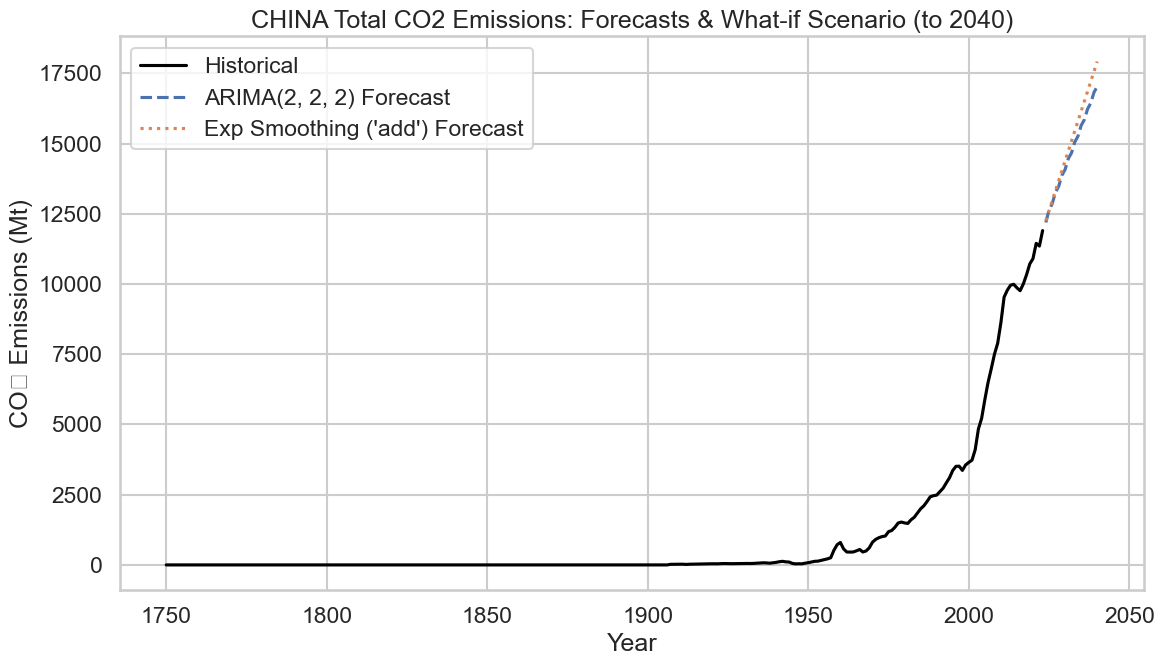


ARIMA(2, 2, 2) (AIC=3217.96) Forecasted Emissions:
  2030: 14074.24 Mt CO₂
  2040: 17032.03 Mt CO₂

Exp Smoothing ('add') (AIC=2492.01) Forecasted Emissions:
  2030: 14380.94 Mt CO₂
  2040: 17921.56 Mt CO₂


In [ ]:
# ----------- Main Usage -----------
country = 'CHINA'
emission_col = 'co2'

# --- Code 1: Model Selection ---
ts = load_country_series(INPUT_PATH, country, emission_col)
arima_order, arima_aic = find_best_arima(ts)
es_trend, es_aic = find_best_es_trend(ts)

print("\nSummary of Best Models:")
print(f"  Best ARIMA order: {arima_order} (AIC={arima_aic:.2f})")
print(f"  Best Exponential Smoothing trend: {es_trend} (AIC={es_aic:.2f})")

# --- Code 2: Forecasting and Plotting ---
forecast_and_plot(ts, arima_order, es_trend)

- **Black line:** Historical emissions (1750–2022).  
- **Blue dashed line:** ARIMA(2,2,2) forecast → AIC = 3217.96.  
- **Orange dotted line:** Exponential Smoothing (‘add’) forecast → AIC = 2492.01 (better fit).  
- Both models predict **continued steep growth** through 2040.  
- **2030:** ~14,000 Mt CO₂ | **2040:** ~17,500 Mt CO₂.  

Takeaway: China’s emissions are projected to rise **~30% between 2030 and 2040** under current trends.
